### Intro: General problem and example problem

### What does it mean?

### How well does it work? 

### Where does it work well? Where does it not work well? 

### Outro: data science vs. data forensics

# Open data, private data, big data, small data

_The technological innovation of differential privacy allows sharing of personal data with privacy guarantees—but implementing differential privacy should makes us think about what we want to get from an open dataset._ 

By Tim McGovern


Apple made headlines (and caused some headscratching) with their announcement this summer that that they’d be widely implementing a technique called “differential privacy” to ensure the privacy of personal data they were gathering—while still keeping it useful to their data scientists and developers. In this post, I’ll give an introduction to differential privacy, model a very simple example of implementing it, and tease out some of its implications, particularly for open data advocates and users. 

### “Have you cheated on any exams?”

Imagine you’re a university researcher, trying to figure out the prevalence of cheating on your campus. You want to ensure the privacy of your respondents’ answers—they will speak more freely if guaranteed absolute privacy. And you and they will be protected from prosecution, of course! 

Here’s a procedure you could implement: each respondent is given a survey, as well as a coin to flip. When they get to the question about cheating, they’re instructed to flip the coin: if it comes up heads, they answer correctly, if it comes up tails, then they flip the coin again and answer “yes” if it comes up heads and “no” if it comes up tails, without any regard for what the truth of their behavor is. (We'll leave aside the question of survey design here, but assume that we've got a well-defined survey question. We'll also ask a few other questions on our survey because we want to learn about not just the overall prevalence of cheating on campus, but its distribution. So we'll be sure to ask about what classes the students are in, what year in school they are, their gender, their socio-economic background and other things that we might look for correlations with.)

It's easy enough to see that this will protect any individual student's privacy, and—after we subtract out the estimated number of random "yes" answers—give us a general idea of the prevalence of cheating on our campus. But why would this be better than simply anonymizing our responses? And what's "differential" about this form of privacy? 

There is a short answer to the first of those questions, which is that this form of data-gathering is highly trustable; any student can see that the data being gathered is mixed with randomness in such a way that their own response is, essentially, meaningless. This takes us to a larger point, which is that _the statistical properties of the dataset are not meaningfully changed by the inclusion or exclusion of an individual's data_. 

This is an important point to be made, because of the way that _deanonymization_ works. If we were to gather our survey data without a randomization routine, but merely anonymized, then deanonymization would be trivial, especially in small classes: I might see that there are two instances of cheating in my Advanced Statistics for Computer Scientists class of 20, and be able to tell that while they are "Subject 2542" and "Subject 0941", I can look across the table to other information and see that they are also the only two sophomores in the class. So much for anonymity! 

Even if I don't have access to the full table of data, I can take narrower and narrower slices of the data to deanonymize it: 
1) How many instances of cheating in STATS 205? 2
2) How many instances of cheating in STATS 205 where SUBJECTYEAR = 1? 0
3) How many instances of cheating in STATS 205 where SUBJECTYEAR = 2? 2

What makes differential privacy "differential" is that it is resistant to this form of deanonymization attack: when you take a slice of the data narrow enough to identify individuals, the data becomes too noisy to draw reliable conclusions. Let's look at the implications by building out an example, surveying cheating in college among 500 respondents.

In [2]:
import random
import matplotlib.pyplot as plt 
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np 
%matplotlib inline
import csv
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

In [3]:
'''Let's define ground truth as 25% of respondents having cheated, 
and we'll keep it super-simple: respondents 0-124 have, and 125-499 have not.''' 
groundtruth = {}
for n in range(0,125):
    groundtruth[n] = 1
for n in range(125,500):
    groundtruth[n] = 0

In [4]:
#Our survey procedure model will return either an accurate or a random answer.

def survey(n,truth):
    firstflip = random.randint(0,1)
    if firstflip:
        return(truth)
    else:
        return(random.randint(0,1))


In [5]:
#Let's run the survey on our sample population:

cheaters = 0
for student in groundtruth:
    cheaters += survey(student,groundtruth[student])
cheaters

186

## What does it mean? 

We now have six categories of answers: 

<table>
    <tr>
        <td> </td>
        <td>*Cheated* </td>
        <td> *Didn't cheat* </td>
    </tr>
    <tr>
        <td>Told the truth</td>
        <td>Truthfully said  they've cheated: **YES** (~50% of the 125 dealers)</td>
        <td>Truthfully said they haven't: **NO**  (~50% of the 375 non-dealers)</td>
    </tr>
    <tr>
        <td>Flipped coin for answer, got heads, *adds up to 25% of total sample*</td>
        <td>**YES** (~25% of 125 cheaters)</td>
        <td>**YES** (~25% of 375 non-cheaters)</td>
    </tr>
    <tr>
        <td>Flipped coin for answer, got tails, *adds up to 25% of total sample* </td>
        <td>**NO** (~25% of 125 cheaters)</td>
        <td>**NO** (~25% of 375 non-cheaters)</td>
    </tr>
<table>    
But let's put ourselves in the shoes of the university researcher—we don't know the number of cheaters! 

Math to the rescue. Let's simplify just a little bit and only worry about our 'yes' survey results. 

>Cheaters who gave a truth-based answer of *YES* (`realcheaters * 0.5`) 

>Cheaters and non-cheaters who gave a coin-flip-based answer of *YES* (500 * 0.25`)

Simplifying: 

`realcheaters * 0.5 + (500 * 0.25) = cheaters
realcheaters * 0.5 + 125 = cheaters
realcheaters * 0.5 = cheaters - 125
realcheaters = (cheaters - 125) * 2`

In [6]:
realcheaters = (cheaters - 125) * 2
realcheaters

122

## Okay, so how well does it work?

Okay, so we got an answer not too far off from what we know ground truth to be (When I ran the simulation, I got 122). But how well does this work out in aggregate? What would happen if we ran our survey, say, 10,000 times? 


In [7]:
#Starting from the same groundtruth data, we'll run the exact same survey 10,000 times. 
#Thank God these are virtual, not real, college students. 


aggregateresults = []
for n in range(0,10000):
    cheaters = 0
    for student in groundtruth:
        cheaters += survey(student,groundtruth[student])
    realcheaters = (cheaters - 125) * 2 #NOTE: we're multiplying an integer by 2, our RESOLUTION is 2
    aggregateresults.append(int(realcheaters))
   

In [8]:
# This just makes graphing it a little easier, by taking the empty slots out of the bins
graphaggres = [int(res/2) for res in aggregateresults] 

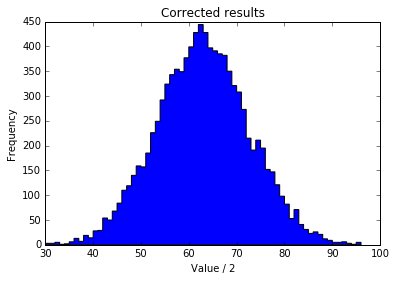

In [9]:
bincount = max(graphaggres) - min(graphaggres)
plt.hist(graphaggres, bins=bincount, histtype='stepfilled')
plt.title("Corrected results")
plt.xlabel("Value / 2")
plt.ylabel("Frequency");


In [16]:
np.mean(aggregateresults) 

124.9682

In [11]:
np.median(aggregateresults)

124.0

In [18]:
np.std(aggregateresults)

19.27827245268621

In [20]:
np.max(aggregateresults)

192

In [19]:
np.min(aggregateresults)

60

Hopefully, I've convinced you that this method of data gathering produces a result that's distributed around the real, ground-truth, number, with a standard deviation of about 19.3. 

## What are the limits of this method of data gathering?  

We've seen that for a ground truth of 125/500, we're probably going to get a result that's about right. There will be outliers; we may run our experiment and return an estimate as low as 60, or as high as 192. But we can work with the value our survey returns, while remaining aware of its limitations as a sample. We also know that any individual survey response is only 50% likely to be accurate, so there's no way to use this data to make any privacy-violating queries on the survey results about any individual student. 

But where can we draw the line? How small a group can we make useful inferences about? Intuitively, we know that as the group we're interested in gets smaller, the results get more randomness. This, it turns out, is prec





We know that `realcheaters` is a probabilistic function distributed around `groundtruth` for any particular value of `realcheaters` and `groundtruth`, and there are statistical equations that have done this math for us, but because I'm using computers to do this (and, umm, I never learned statistics) I'm going to make the computer do this all by means of simulations, i.e., The loooooooong way. 

Onward. 

### The problem, more or less succinctly stated

For a given number `realcheaters` and percentage confident `conf` we want to know the range around it for which other groundtruths produce a `realcheaters` result `conf` percent of the time or greater. So we can pre-calculate 10,000 `realcheaters` results for _every_ possible `groundtruth`. 

In [13]:
'''Commenting out this whole cell, because it takes a long time to run. 

def simulation(cheatersseq):
    groundtruth = {}
    for n in range(0,cheatersseq):
        groundtruth[n] = 1
    for n in range(cheatersseq,500):
        groundtruth[n] = 0
        
    aggregateresults = []
    for n in range(0,10000):
        surveydata = []
        for student in groundtruth:
            surveydata.append(survey(student,groundtruth[student]))
        dealers = 0
        for n in surveydata:
            if n[1] == 1:
                dealers += 1
        realdealers = (dealers - 125) * 2
        aggregateresults.append(realdealers)
    return(aggregateresults)
    
#I actually ran this in batches.
output_file = '101_200times.csv'
with open(output_file, 'w', newline='') as filewriter:
    for n in range(101,200):
        filewriter.write(str(simulation(n)))
        filewriter.write('\n')
'''

"Commenting out this whole cell, because it takes a long time to run. \n\ndef simulation(cheatersseq):\n    groundtruth = {}\n    for n in range(0,cheatersseq):\n        groundtruth[n] = 1\n    for n in range(cheatersseq,500):\n        groundtruth[n] = 0\n        \n    aggregateresults = []\n    for n in range(0,10000):\n        surveydata = []\n        for student in groundtruth:\n            surveydata.append(survey(student,groundtruth[student]))\n        dealers = 0\n        for n in surveydata:\n            if n[1] == 1:\n                dealers += 1\n        realdealers = (dealers - 125) * 2\n        aggregateresults.append(realdealers)\n    return(aggregateresults)\n    \n#I actually ran this in batches.\noutput_file = '101_200times.csv'\nwith open(output_file, 'w', newline='') as filewriter:\n    for n in range(101,200):\n        filewriter.write(str(simulation(n)))\n        filewriter.write('\n')\n"

In [22]:
#Open up the file where I stored all those results
bigagg = []

input_files = ["50times.csv", "51_100times.csv","101_200times.csv","201_500times.csv"]
for input_file in input_files:
    with open(input_file, 'r', newline='') as csv_in_file:
        filereader = csv.reader(csv_in_file, delimiter = ',')
        for row in filereader:
            bigagg.append(row)        

In [23]:
#All those numbers are text, we need to clean 'em up a little: 
for row in bigagg:
    row[0] = row[0].lstrip('[')
    row[-1] = row[-1].rstrip(']')

bigagg = [[int(m) for m in row] for row in bigagg]


In [24]:
#We're going to run some calculations and graphs but it helps not to hit NaNs when we do it. 
overallmin = min([min(agg) for agg in bigagg])
overallmax = max([max(agg) for agg in bigagg])


### We need to re-orient our data a bit. 

Right now we have a table (properly speaking, because I'm doing this in native Python, it's a list of lists) where each row represents all the survey outcomes that a given ground truth (== the row index) produced. What we want is a table where each of the rows represents a _result_ and each element in that row represents a ground truth that produced it. 

In [25]:
#This takes 5 or so minutes when we do it with all 5 million results. Should re-do with up to 200 for demo.
reresults = {}
for n in range(overallmin, overallmax):
    reresults[n] = []
    for m in range(0, len(bigagg)):
        for p in bigagg[m]:
            if p == n:
                reresults[n].append(m)
        

In [26]:
np.mean(reresults[100])

100.0653205451792

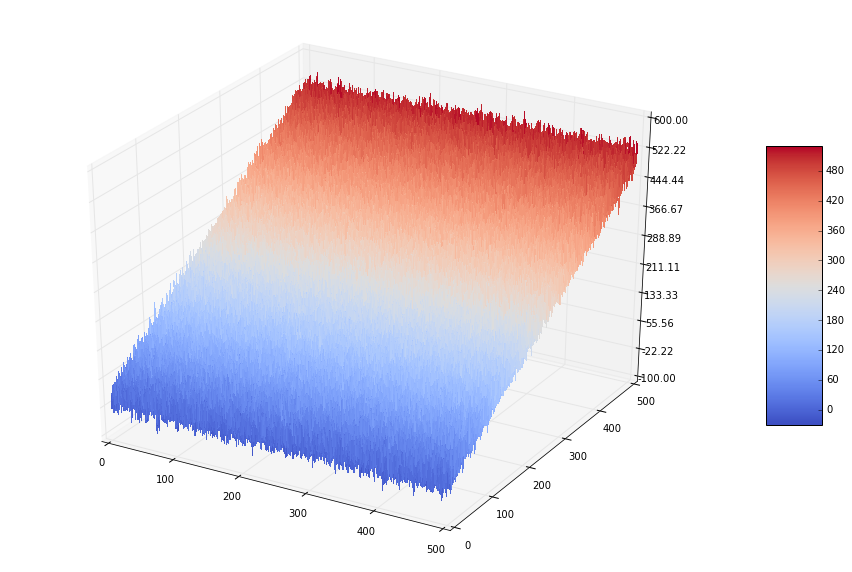

In [27]:
fig = plt.figure(figsize=(16,10))
ax = fig.gca(projection='3d')
x = [n for n in range(0,1000,2)] #Every other row so we don't graph all the zeroes.
y = [n for n in range(0,500)]
z = []
for row in bigagg:
    shortened = []
    for n in range(0,1000,2):
        shortened.append(row[n])
    z.append(shortened)
z = [[float(m) for m in n] for n in z]
xs = [[m for m in range(len(x))] for n in range(len(y))]
ys = [[n for m in range(len(y))] for n in range(len(x))]
zs = [[elem for elem in row] for row in z]

surf = ax.plot_surface(xs, ys, zs, rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)


ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [28]:
#Let's visualize stuff. We need to get rid of empty rows to graph things out. 
xs = []
for n in range(overallmin,overallmax):
    if len(reresults[n]):
        xs.append(n)
        

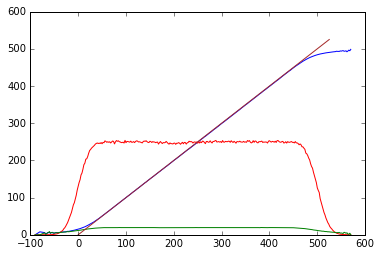

In [30]:
y1 = [np.mean(reresults[n]) for n in xs]
y2 = [len(reresults[n]) / 80 for n in xs]
y3 = [np.std(reresults[n]) for n in xs]


plt.plot(xs, y1, color='blue')
plt.plot(xs, y2, color='red')
plt.plot(xs, y3, color='green')
plt.plot(range(0,(overallmax-50)), range(0,(overallmax-50)), color='brown');


In [35]:
len(xs)

323